# Bank Scoring

В этом соревновании нам предстоит предсказать вероятность отнесения к классу "дефолтных" потенциальных клиентов банка за 48 ч.

## Импорт библиотек

In [2]:
import numpy as np 
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns 
import random
%matplotlib inline
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import auc, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier

In [3]:
# фиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы
!pip freeze > requirements.txt

In [4]:
import warnings
warnings.filterwarnings("ignore")

## Прописываем формулы

In [5]:
def ShowPlots(list):
    '''построим гистограммы для опредленных колонок данных, чтобы посмотреть распределение'''
    data[list].hist(figsize=(15,10))

def ShowPlotsLog(list):
    '''построим гистограммы для опредленных колонок данных, чтобы посмотреть распределение, но уже после логарифмирования'''
    for i in list:
        data[i]=np.log(data[i]+1)
    data[list].hist(figsize=(15,10))

def ShowBoxplots(list):
    '''построим boxplot’ы для опредленных колонок данных, чтобы посмотреть на дефолтных клиентов'''
    for i in list:
        fig,ax=plt.subplots(figsize=(10,4))
        sns.boxplot(y=i,x='default', data=data[data['default']>=0])
        plt.title(i)
        plt.show()
        
def ShowRocAuc(model,X_test,y_test):
    '''оценим качество прогностической способности модели через ROC-анализ'''
    probs = model.predict_proba(X_test)
    probs = probs[:,1]


    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()
    
def BestHyperparms(model,X_train, y_train):
    iter_ = 50
    epsilon_stop = 1e-3
    param_grid = [
        {'penalty': ['l1'], 
         'solver': ['liblinear', 'lbfgs'], 
         'class_weight':['none', 'balanced'], 
         'multi_class': ['auto','ovr'], 
         'max_iter':[iter_],
         'tol':[epsilon_stop]},
        {'penalty': ['l2'], 
         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
         'class_weight':['none', 'balanced'], 
         'multi_class': ['auto','ovr'], 
         'max_iter':[iter_],
         'tol':[epsilon_stop]},
        {'penalty': ['none'], 
         'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
         'class_weight':['none', 'balanced'], 
         'multi_class': ['auto','ovr'], 
         'max_iter':[iter_],
         'tol':[epsilon_stop]},]
    
    gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
    gridsearch.fit(X_train, y_train)
    model = gridsearch.best_estimator_
    ##печатаем параметры
    best_parameters = model.get_params()
    for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))
    
def Outliers(list):
    '''определяем квартили и границы выбросов для определенных признаков'''
    for column in list:
        perc25 = data[column].quantile(0.25)
        perc75 = data[column].quantile(0.75)
        IQR = perc75 - perc25
        low = perc25 - 1.5*IQR
        up = perc75 + 1.5*IQR
        print (column)
        k = 0
        for i in data[column]:
            if i <= low or i >= up:
                k+= 1
        if k > 0:
            print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
                  , "IQR: {}, ".format(IQR),"Границы выбросов: [{}, {}],".format(low,up), 'Количество выбросов - ', k)
        else:
            print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
                  , "IQR: {}, ".format(IQR), "Границы выбросов: [{}, {}],".format(low,up), 'Выбросов нет') 


def OutliersUniform(col):
    '''находим выбросы и задаем значение внутри границ выбросов'''
    x=0
    perc25, perc75 = np.percentile(col, [25, 75])
    IQR = perc75 - perc25
    low = perc25 - 1.5*IQR
    up = perc75 + 1.5*IQR
    if type(col[0])==int:
        x=random.randint(low,up)
    else:
        x=random.uniform(low,up)
    for i in range(len(col)):
        if col[i] < low or col[i] > up:
            col[i] = x

def CarMerge(row):
    '''находим в строке наличие авто, если авто есть, то проверяем иномарка или местная''' 
    if row['car'] == 0:
        return 0
    if row['car'] == 1 and row['car_type'] == 0:
        return 1 
    if row['car'] == 1 and row['car_type'] == 1:
        return 2
    if home == work:
        return 1 
    else:
        return 0 

def AddrMerge(add_home,add_work):
    if add_home == add_work:
        return 1 
    else:
        return 0 

## Импорт данных

In [6]:
#DATA_DIR = '/kaggle/input/sf-dst-scoring/'
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
#sample_submission = pd.read_csv(DATA_DIR+'sample_submission.csv')

In [7]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['default'] = -1 # в тесте у нас нет значения default, мы его должны предсказать, поэтому пока просто заполняем значением "-1"

data = df_train.append(df_test, sort=False).reset_index(drop=True) # объединяем

#### Резюме по предварительному анализу: 
 - в тренировочном наборе данных 73 799 клиента;
 - в тестовом наборе данных - 36 349 клиента;
 - всего клиентов в обеих выборках: 110 148 клиентах.

Всего 20 переменных:

#### Временные признаки:
 - app_date - дата заполнения заявки;
 
#### Бинарные признаки:
  - sex - пол заемщика;
  - car - флаг наличия автомобиля;
  - car_type - флаг автомобиля иномарки;
  - good_work - флаг наличия “хорошей” работы;
  - foreign_passport - наличие загранпаспорта;
  - default - флаг дефолта;
  - sample - определение тестовая/тренировочная база данных;
  
#### Категориальные признаки:
  - education - уровень образования;
  - home_address - категоризатор домашнего адреса;
  - work_address - категоризатор рабочего адреса;
  - sna - связь заемщика с клиентами банка;
  - first_time - давность наличия информации о заемщике;
  - region_rating - рейтинг региона;

#### Числовые признаки:
  - age - возраст заемщика;
  - decline_app_cnt - количество отказанных прошлых заявок;
  - bki_request_cnt - количество запросов в БКИ;
  - income - доход заемщика;
  - score_bki - рейтинг кредитного бюро;
  - client_id - идентификатор клиента.

## Cleaning and Prepping Data

### 1. Обработка NAN

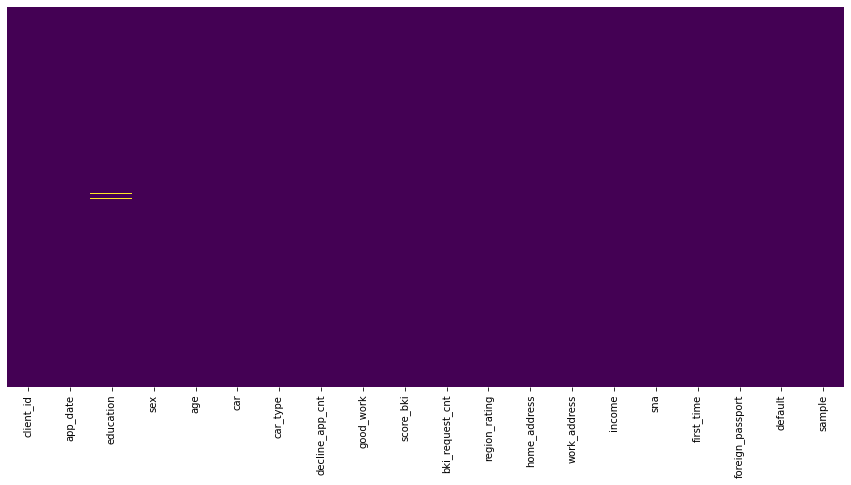

In [9]:
fig, ax = plt.subplots(figsize=(15,7))
sns_heatmap = sns.heatmap(data.sample(1000).isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [10]:
data.isnull().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
sample                0
dtype: int64

 Всего пропусков 478 (0.4%), отсутствуют значения только в колонке "education". Cоздадим отдельный столбец, где отражены пропущенные данные, возможно отсутствующие данные  - тоже имеют значение. Пропущенные значения по образованию заполняем наиболее часто встречающимся значением.

In [11]:
data['education_isNAN'] = pd.isna(data['education']).astype('uint8')

data['education'].fillna(data['education'].value_counts().index[0], inplace=True)

### 2. Обработка признаков

Обработаем для начала единственный признак временного ряда, это дата подачи заявки на кредитование

In [12]:
# Преобразуем формат признака
data.app_date = pd.to_datetime(data.app_date, format='%d%b%Y')
date_start= data.app_date.min()
date_end = data.app_date.max()
date_start, date_end

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-04-30 00:00:00'))

Введем новые признаки (отдельно выведем день, месяц и разницу от даты подачи заявки и с первональное датой отчета, т.е. 1 января 2014). Вообще весь отчет сформирован за опредленный период: с 1 января 2014 по и 30 апреля 2014 года

In [13]:
data['date'] = data.app_date.dt.day
data['month'] = data.app_date.dt.month
data['days'] = (data.app_date - date_start).dt.days.astype('int')

In [14]:
data.describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default,sample,education_isNAN,date,month,days
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000
mean,55074.500000,39.249410,0.273205,0.165514,-1.904535,2.005002,56.751189,1.574945,2.497867,41012.648537,1.731588,2.765570,-0.244916,0.669999,0.004340,15.959100,2.535107,60.971466
std,31797.133063,11.518063,0.799099,0.371645,0.499397,2.266926,13.065923,0.527562,0.687651,45399.735051,1.122652,1.010151,0.595908,0.470215,0.065733,8.598467,1.087680,32.076078
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,-1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,27537.750000,30.000000,0.000000,0.000000,-2.260434,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,-1.000000,0.000000,0.000000,9.000000,2.000000,33.000000
50%,55074.500000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,0.000000,1.000000,0.000000,16.000000,3.000000,62.000000
75%,82611.250000,48.000000,0.000000,0.000000,-1.567888,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,0.000000,1.000000,0.000000,23.000000,3.000000,89.000000
max,110148.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000,1.000000,1.000000,31.000000,4.000000,119.000000


Полученные признаки сгруппируем в три категории по типу их обработки (категориальные, бинарные и числовые) для дальнейшего удобного анализа. Отбросим client_id (не будет полезен при анализе), default (целевая переменная) и sample (разделитель на трен/тест)

In [15]:
data['positrequest']=data['bki_request_cnt']-data['decline_app_cnt']

In [16]:
bin_cols = ['sex','car','car_type','good_work','foreign_passport','education_isNAN']
cat_cols = ['education','work_address','home_address','sna','first_time','region_rating']
num_cols = ['income','age','bki_request_cnt','decline_app_cnt','score_bki','date','days','month','positrequest']

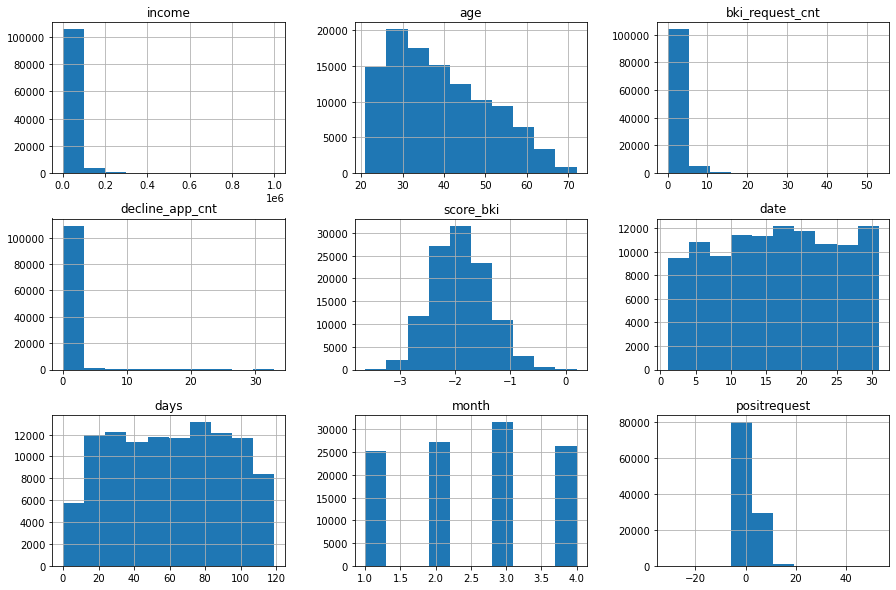

In [17]:
# посмотрим числовые признаки
ShowPlots(num_cols)

После построения гистограмм стало очевидно, что распределения некоторых числовых переменных имеют тяжёлый правый хвост. Прологорифмируем некотторые из них и посмотрим на графики еще раз

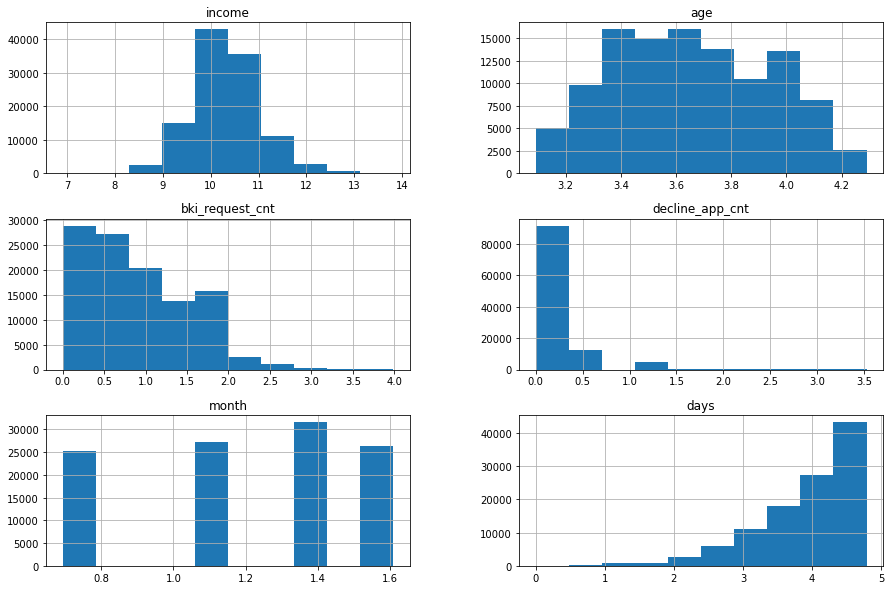

In [18]:
#тк скоринговый балл и дни/месяцы распределены нормально их не логорифмируем, оставляем как есть
data['positrequest']=np.log(data['positrequest']+1)
num_cols_log = ['income','age','bki_request_cnt','decline_app_cnt','month','days']
ShowPlotsLog(num_cols_log)

распредление признаков логнормальное

In [19]:
# проверим числовые переменные на выбросы
Outliers(num_cols)

income
25-й перцентиль: 9.90353755128617, 75-й перцентиль: 10.778977123006351, IQR: 0.8754395717201806,  Границы выбросов: [8.590378193705899, 12.092136480586621], Количество выбросов -  2609
age
25-й перцентиль: 3.4339872044851463, 75-й перцентиль: 3.8918202981106265, IQR: 0.4578330936254802,  Границы выбросов: [2.7472375640469258, 4.5785699385488465], Выбросов нет
bki_request_cnt
25-й перцентиль: 0.0, 75-й перцентиль: 1.3862943611198906, IQR: 1.3862943611198906,  Границы выбросов: [-2.0794415416798357, 3.465735902799726], Количество выбросов -  15
decline_app_cnt
25-й перцентиль: 0.0, 75-й перцентиль: 0.0, IQR: 0.0,  Границы выбросов: [0.0, 0.0], Количество выбросов -  110148
score_bki
25-й перцентиль: -2.2604336700000003, 75-й перцентиль: -1.5678881525, IQR: 0.6925455175000004,  Границы выбросов: [-3.299251946250001, -0.5290698762499992], Количество выбросов -  518
date
25-й перцентиль: 9.0, 75-й перцентиль: 23.0, IQR: 14.0,  Границы выбросов: [-12.0, 44.0], Выбросов нет
days
25-й п

избавимся от выбросов

In [20]:
del_outliers_col =  ['income','bki_request_cnt','score_bki']
for col in del_outliers_col:
    OutliersUniform(data[col])

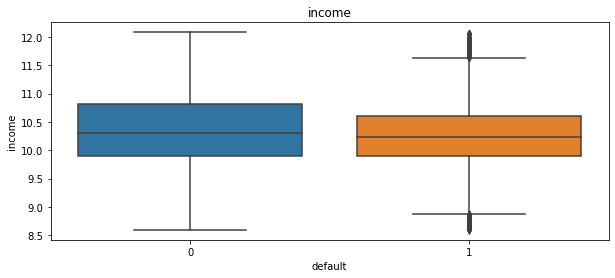

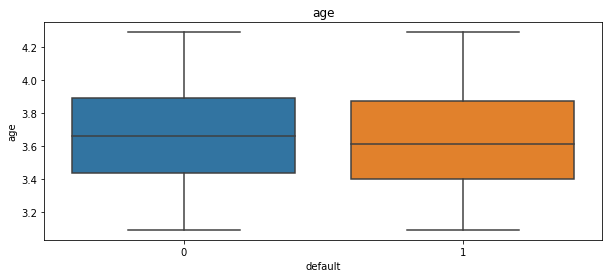

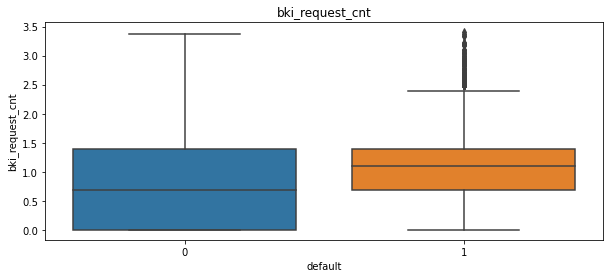

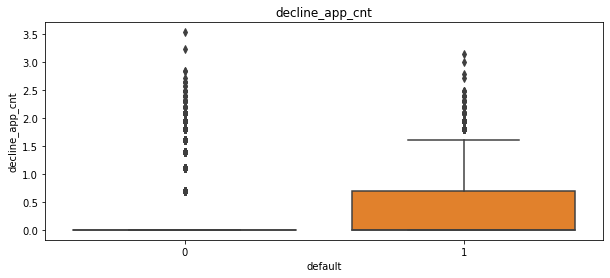

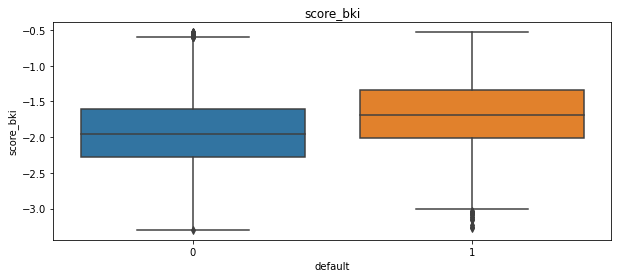

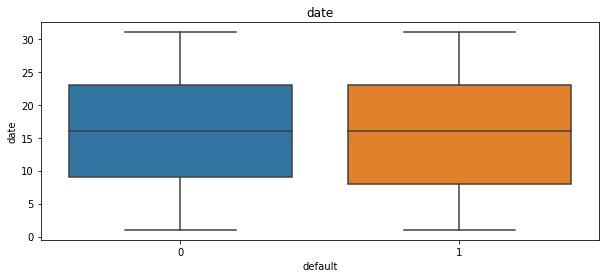

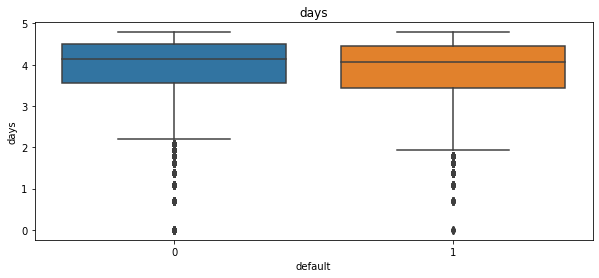

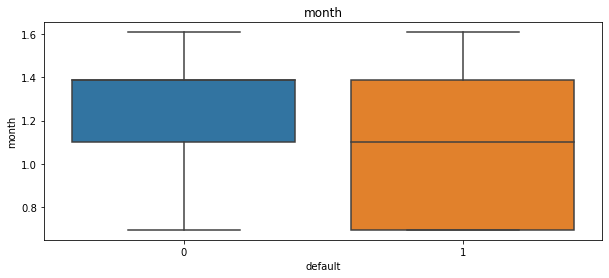

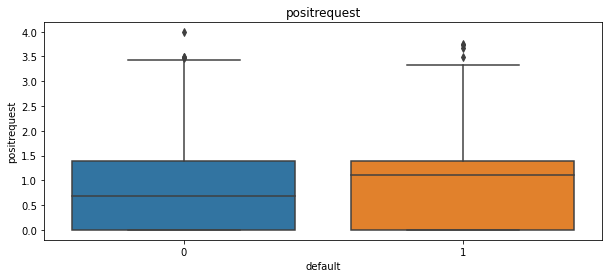

In [21]:
ShowBoxplots(num_cols)

Судя по коробкам с усами можем сделать выводы: очевидно что в среднем доходы дефолтных клиентов ниже, но при этом скоринговый балл выше - значит чем выше балл тем хуже??? хотя должно быть по идее наоборот. Количество отказов по дефолтным намного больше и возраст в среднем ниже, видимо чем старше клиент тем более ответственный))

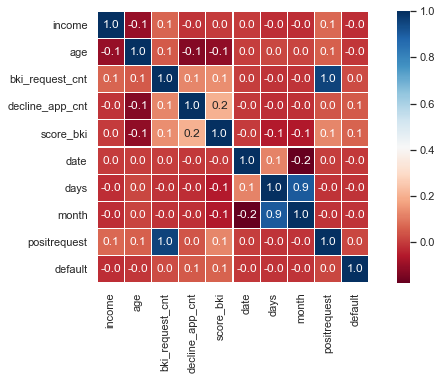

In [22]:
# теперь посмотрим на корреляцию числовых признаков между собой
num_cols_def = ['income','age','bki_request_cnt','decline_app_cnt','score_bki','date','days','month','positrequest','default']
sns.set (font_scale=1)
plt.subplots (figsize=(10,5))
sns.heatmap(data[num_cols_def].corr(), square=True, annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

Сильно коррелируют друг с другом признаки признак "positrequest" со всеми заявками БКИ, выкинем из датасета этот признак

In [23]:
#удалим месяц и день подачи заявки
data.drop(['positrequest'], axis=1, inplace=True)
num_cols = ['income','age','bki_request_cnt','decline_app_cnt','score_bki','date','days','month']

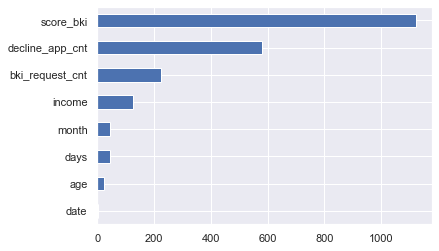

In [24]:
imp_num = pd.Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Посмотрев насколько сильно влияют числовые признаки на признак дефолта, понимаем что дата заявки не несет в себе особо никакого эффекта, можем смело удалить. Самые сильные признаки: скоринговый балл кредитного бюро, кол-во отклоненных заявок и кол-во запросов в кредитное бюро.

In [25]:
#удалим день подачи заявки
data.drop(['date'], axis=1, inplace=True)

In [26]:
num_cols = ['income','age','bki_request_cnt','decline_app_cnt','score_bki','days','month']

обработаем теперь не числовые признаки, воспользуемся LabelEncoder() и попытаемся обернуть все бинарные признаки

In [27]:
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

In [28]:
  #воспользуемся также LabelEncoder() для признака образование и выведем все промапенные значения, чтобы не забыть

mapped_education = pd.Series(label_encoder.fit_transform(data['education']))
print(dict(enumerate(label_encoder.classes_)))
data.education = pd.Series(label_encoder.fit_transform(data['education']))

{0: 'ACD', 1: 'GRD', 2: 'PGR', 3: 'SCH', 4: 'UGR'}


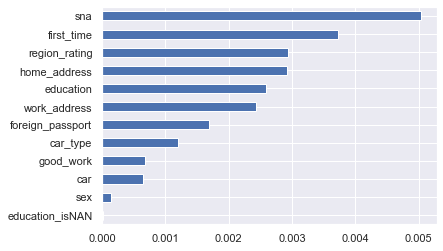

In [29]:
imp_cat = pd.Series(mutual_info_classif(data[bin_cols+cat_cols], data['default'],discrete_features =True), index = bin_cols+cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

мы видим что сильнейшими признаками, коррелирующим с признаком дефолта являются связь с другим клиентом Банка, а также давность наличия информации о заемщике. Отсутвие информации об образовании нам ничего не дает, можно удалить этот признак.

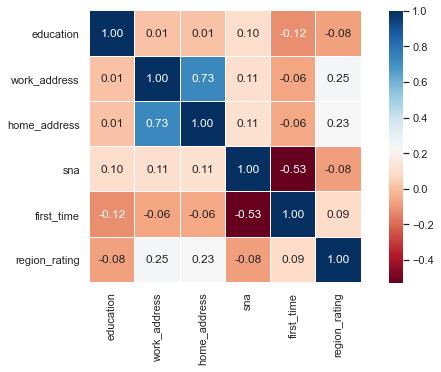

In [30]:
# теперь посмотрим на корреляцию признаков между собой
sns.set (font_scale=1)
plt.subplots (figsize=(10,5))
sns.heatmap(data[cat_cols].corr(), square=True, annot=True, fmt=".2f", linewidths=0.1, cmap="RdBu")

сильно коррелируют друг с другом домашний адрес и рабочий адрес, создадим новый признак и удалим рабочий адрес

In [31]:
data['address2'] = data.apply(lambda row: AddrMerge(row['home_address'],row['work_address']),axis=1)

In [32]:
#удалим "education_isNAN", "work_address"

data.drop(['education_isNAN','work_address'], axis=1, inplace=True)
bin_cols = ['car','car_type','good_work','foreign_passport','sex','address2']

In [33]:
# объединим два признака наличие машины и если машина есть, то иномарка ли она

data['car_type2'] = data.apply(lambda row: CarMerge(row), axis=1)

bin_cols = ['sex','good_work','foreign_passport','address2']
cat_cols = ['education','home_address','sna','first_time','region_rating','car_type2']
data.drop(['car','car_type'], axis=1, inplace=True)

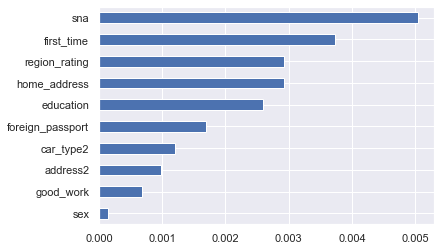

In [34]:
imp_cat = pd.Series(mutual_info_classif(data[bin_cols+cat_cols], data['default'],discrete_features =True), index = bin_cols+cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

удалим лишние столбцы:

In [35]:
data.drop(['app_date'], axis=1, inplace=True)

In [36]:
# реализуем метод OneHotLabels через get_dummies для категориальных признаков
data=pd.get_dummies(data, prefix=cat_cols, columns=cat_cols)

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 40 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   sex               110148 non-null  int32  
 2   age               110148 non-null  float64
 3   decline_app_cnt   110148 non-null  float64
 4   good_work         110148 non-null  int64  
 5   score_bki         110148 non-null  float64
 6   bki_request_cnt   110148 non-null  float64
 7   income            110148 non-null  float64
 8   foreign_passport  110148 non-null  int32  
 9   default           110148 non-null  int64  
 10  sample            110148 non-null  int64  
 11  month             110148 non-null  float64
 12  days              110148 non-null  float64
 13  address2          110148 non-null  int64  
 14  education_0       110148 non-null  uint8  
 15  education_1       110148 non-null  uint8  
 16  education_2       11

### 3. Разбиваем выборки на 2 части обратно и стандартизируем каждую часть по отдельности

In [38]:
# Теперь выделим тестовую часть
df_train = data[data['sample'] == 1].drop(['sample', 'client_id'], axis=1)
df_test = data[data['sample'] == 0].drop(['sample', 'client_id'], axis=1)

In [39]:
y = df_train.default.values            # наш таргет
X = df_train.drop(['default'], axis=1)
df_test=df_test.drop(['default'], axis=1)

Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.

In [40]:
# Воспользуемся train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [41]:
transformer = RobustScaler()
X_train_scal = transformer.fit_transform(X_train)
X_test_scal = transformer.fit_transform(X_test)
df_test_scal = transformer.fit_transform(df_test)

In [42]:
# проверяем
df_test.shape, df_train.shape, X.shape, X_train.shape, X_test.shape

((36349, 37), (73799, 38), (73799, 37), (59039, 37), (14760, 37))

## Model

Сначала попробуем обучить модель логистической регрессиЮ без подбора гиперпараметров

In [43]:
model = LogisticRegression()
model.fit(X_train_scal, y_train)

LogisticRegression()

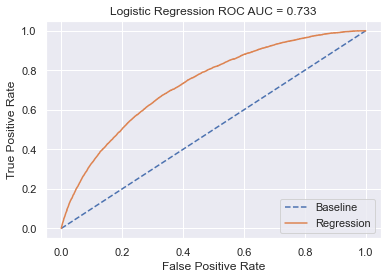

In [44]:
ShowRocAuc(model,X_train_scal,y_train)

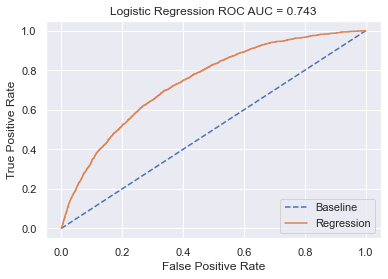

In [45]:
ShowRocAuc(model,X_test_scal,y_test)

In [46]:
y_pred = model.predict(X_test_scal)
confusion_matrix(y_test,y_pred)

array([[12877,    56],
       [ 1793,    34]], dtype=int64)

In [47]:
print('Precision score - ', round(precision_score(y_test,y_pred),4))
print('Recall score - ', round(recall_score(y_test,y_pred),4))
print('F1 score - ', round(f1_score(y_test,y_pred),4))
print('Accuracy score - ', round(accuracy_score(y_test,y_pred),4))

Precision score -  0.3778
Recall score -  0.0186
F1 score -  0.0355
Accuracy score -  0.8747


Мы получили модель с довольно хорошей целевой метрикой ROC-AUC 0.743, но если посмотреть на confusion matrix мы видим большую долю ошибок, об этом нам также говорит метрика 
Recall, которая равна 0.019. Таким образом все клиенты попали в ошибку второго рода, мы не определили потенциально дефолтных клиентов. Данные несбалансированные, поэтому ROC-AUC так плохо оценивает эффективность алгоритма.
Попытаемся подобрать хорошие гиперпараметры, которые возможно улучшат нашу модель и соответсвенно показатели.

In [ ]:
#fold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
#model = LogisticRegressionCV(random_state=RANDOM_SEED,
#                           class_weight='balanced',
#                           fit_intercept=True,
#                           intercept_scaling=1,
#                           max_iter=50,
#                           multi_class='ovr',
#                           penalty='l2',
#                           solver='sag',
#                           verbose=0,
#                           cv=fold) 
#model.fit(X_train_scal, y_train) 

#этим методом модель не показала результатов лучше, была надежда что в данном случае будет учитываться несбалан-ть выборки

In [48]:
BestHyperparms(model,X_train_scal, y_train)

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'ovr'
	n_jobs: None
	penalty: 'none'
	random_state: None
	solver: 'saga'
	tol: 0.001
	verbose: 0
	warm_start: False


In [49]:
model = LogisticRegression(random_state=RANDOM_SEED,
                           C=1,
                           class_weight='balanced',
                           fit_intercept=True,
                           intercept_scaling=1,
                           max_iter=50,
                           multi_class='ovr',
                           penalty='none',
                           solver='saga',
                           verbose=0,
                           tol=0.001,
                           warm_start=False)
model.fit(X_train_scal, y_train)

LogisticRegression(C=1, class_weight='balanced', max_iter=50, multi_class='ovr',
                   penalty='none', random_state=42, solver='saga', tol=0.001)

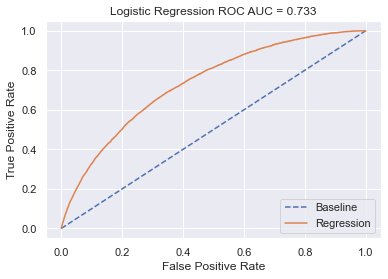

In [50]:
ShowRocAuc(model,X_train_scal,y_train)

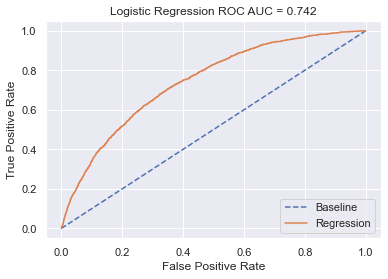

In [51]:
ShowRocAuc(model,X_test_scal,y_test)

In [52]:
y_pred = model.predict(X_test_scal)
confusion_matrix(y_test,y_pred)

array([[8610, 4323],
       [ 571, 1256]], dtype=int64)

In [53]:
print('Precision score - ', round(precision_score(y_test,y_pred),4))
print('Recall score - ', round(recall_score(y_test,y_pred),4))
print('F1 score - ', round(f1_score(y_test,y_pred),4))
print('Accuracy score - ', round(accuracy_score(y_test,y_pred),4))

Precision score -  0.2251
Recall score -  0.6875
F1 score -  0.3392
Accuracy score -  0.6684


Не смотря на то что ROC-AUC чуть-чуть упал, остальные метрики показали лучше результат с подобранными гиперпараметрами в сравнении с первой моделью, но accuracy score снизился,но наша модель лучше находит дефолтных клиентов. 

In [54]:
#хотелось бы попробовать ансамбль из 3 моделей, но код очень долго обрабатывается
estimator=[]
estimator.append(('LR',LogisticRegression()))
estimator.append(('SVC',SVC(probability=True)))
estimator.append(('DTC',DecisionTreeClassifier()))

In [ ]:
model=VotingClassifier(estimator,voting='soft')
model.fit(X_train_scal, y_train)

In [ ]:
sample_submission

In [ ]:
predict_submission = model.predict(df_test_scal)

In [ ]:
sample_submission = pd.DataFrame(data[data['sample'] == 0].client_id)
sample_submission['default'] = predict_submission
sample_submission.to_csv('submission.csv',index=False)
sample_submission.head(10)